In [1]:

! python -m pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()



import tweepy
import numpy as np
import pandas as pd
import os
import re
import time
import pickle
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.svm import SVC
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import nltk
import matplotlib.patheffects as peffects

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, plot_roc_curve
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import time as timelib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
plt.style.use('fivethirtyeight')


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
file = '/content/drive/MyDrive/tweet_data.csv'

In [3]:
colnames = ['target', 'id', 'date','flag','user','text']

In [4]:
originalDataDF = pd.read_csv('data/tweet_data.csv', names=colnames, delimiter=',' ,engine='python', nrows=None, encoding='latin-1', header=None)

In [5]:
originalDataDF.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
def handling_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    
    return text

In [7]:
# cleaning the text

# removing tagged username '@'
def cleaningText(text):
    text = text.strip('\'"?!,.():;') # removing punctuation
    text = re.sub(r'(.)\1+', r'\1\1', text) # convert more than 2 letter repetitions to 2 letter #fooood -> food
    text = re.sub(r'(-|\')','',text) # removing additional -& '
    text = re.sub(r'@[A-Za-z0-9]+','',text) #removing @usernames
    text = re.sub(r'#','',text) #removing '#' symbols
    text = re.sub(r'RT[\s]+','',text) #removes RT(Re-Tweet) string 
    text = re.sub(r'https?:\/\/\S+','',text) #removing the hyperlink
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', text) #removing urls
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Strip space, " and ' from tweet
    text = text.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    text = handling_emojis(text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    text = text.lower() #make the text to lowercase
    return text


In [8]:
originalDataDF['text'] = originalDataDF['text'].apply(cleaningText)
originalDataDF['text'][0]

'aww, thats a bummer. you shoulda got david carr of third day to do it. emo_pos '

In [9]:
contractionWords = {
"aren’t":"are not","can’t":"can not","couldn’t":"could not ","didn’t":"did not","doesn’t":"does not","don’t":"do not","hadn’t":"had not","hasn’t":"has not ","haven’t":"have not",
"I’m":"I am","I’ve":"I have","isn’t":"is not","let’s":"let us","mightn’t":"might not","mustn’t":"must not","shan’t":"shall not","shouldn’t":"should not","that’s":" that is","he’ll":" he will",
"I’ll":"I will","she’ll":"she will","she’s":"she is","there’s":"there is","they’ll":" they will","they’re":"they are","they’ve":"they have","we’re":"we are","we’ve":"we have","weren’t":"were not",
"what’ll":"what will","what’re":"what are","what’ve":"what have","where’s":"where is","who’d":"who would","who’ll":"who will","who’re":"who are","who’s":"who is","who’ve":"who have","won’t":"will not",
"wouldn’t":"would not","you’d":"you would","you’re":"you are","you’ve":"you have","it’s":"it is","wasn't":"was not"
}

In [10]:
# negation handling
def negationHandling(text):
    words = text.split()
    temp = [contractionWords[word] if word in contractionWords else word for word in words]
    temp = " ".join(temp)
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(negationHandling)

In [11]:
word_set = []
def wordTokenize(text):
    tokens = word_tokenize(text)
    return tokens
originalDataDF['text'] = originalDataDF['text'].apply(wordTokenize)
originalDataDF['text'][0]

['aww',
 ',',
 'thats',
 'a',
 'bummer',
 '.',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 '.',
 'emo_pos']

In [12]:
stop_words = stopwords.words('english')
def removeStopWords(tokens):
    temp = [word for word in tokens if word not in stop_words]
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(removeStopWords)
originalDataDF['text'][0]

['aww',
 ',',
 'thats',
 'bummer',
 '.',
 'shoulda',
 'got',
 'david',
 'carr',
 'third',
 'day',
 '.',
 'emo_pos']

In [13]:
def removeUnnecessaryChars(tokens):
    temp = [word for word in tokens if word.isalpha()]
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(removeUnnecessaryChars)
originalDataDF['text'][0]

['aww', 'thats', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

In [14]:
lemma = WordNetLemmatizer()
def lemmatizeTweets(wordList):
    temp = []
    for word in wordList:
        _word = lemma.lemmatize(word)
        temp.append(_word)
    return ' '.join(temp)
originalDataDF['text'] = originalDataDF['text'].apply(lemmatizeTweets)


In [15]:
def datasplitfortraining(l1=[],l2=[],m=0):
    k = 0
    for i in range(len(originalDataDF)):
        if(k==46000):
            break
        if originalDataDF['target'][i] == m:
            l1.append(originalDataDF['target'][i])
            l2.append(originalDataDF['text'][i])
            k+=1
    newmodifieddf = pd.DataFrame({'target':l1,'text':l2})
    return newmodifieddf



d1 = datasplitfortraining(m=4)
d2 = datasplitfortraining(m=2)
d3 = datasplitfortraining(m=0)

In [16]:
d3

,target,text
0,4,love u guy r best
1,4,im meeting one besties tonight cant wait girl ...
2,4,thanks twitter add sunisa got meet hin show dc...
3,4,sick really cheap hurt much eat real food plus...
4,4,effect everyone
...,...,...
91995,0,people acting weird lately want spaghetti
91996,0,totally underestimated amount work ive hgot le...
91997,0,farted nabs woke u way early
91998,0,hand cold


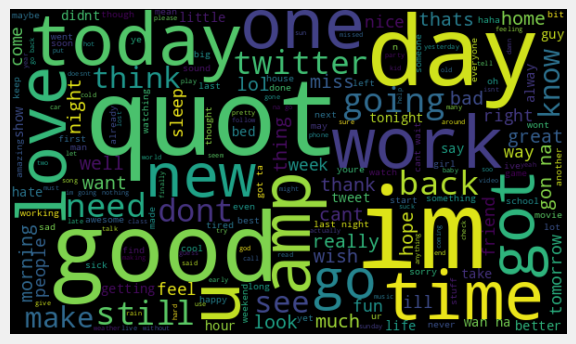

In [17]:
allwords = ''.join([t for t in d3['text']])
wordCloud = WordCloud(width=600,height=350,random_state=59,max_font_size=120).generate(allwords)

plt.imshow(wordCloud, interpolation= "bilinear")
plt.axis('off')
plt.show()

In [18]:
vectorizer = TfidfVectorizer(min_df = 5,max_df=0.8,sublinear_tf = True,use_idf = True)

In [19]:
train_vectors = vectorizer.fit_transform(d3['text'])

In [20]:
X = train_vectors.toarray()
y = np.where(d3['target'] == 0 , -1 , 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [22]:
X_train.shape

(73600, 8631)

In [23]:
y_train.shape

(73600,)

In [24]:
time0 = timelib.time()

In [25]:
svm_model = SVC(kernel='linear')

In [26]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [27]:
time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

Elapsed Time: 17.83 min


In [28]:
preds = svm_model.predict(X_train)

In [29]:
preds

array([ 1, -1,  1, ...,  1,  1,  1])

In [30]:
confusion_matrix = confusion_matrix(y_train,preds)

In [31]:
confusion_matrix

array([[29057,  7743],
       [ 6271, 30529]], dtype=int64)

In [32]:
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

array([0.78959239, 0.82959239])

In [33]:
accuracy_score(y_train,preds)

0.8095923913043478

In [34]:
precision_score(y_train,preds)

0.797684991638796

In [35]:
recall_score(y_train,preds)

0.8295923913043478

In [36]:
f1_score(y_train,preds)

0.8133258738277921

C:\Users\bharg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


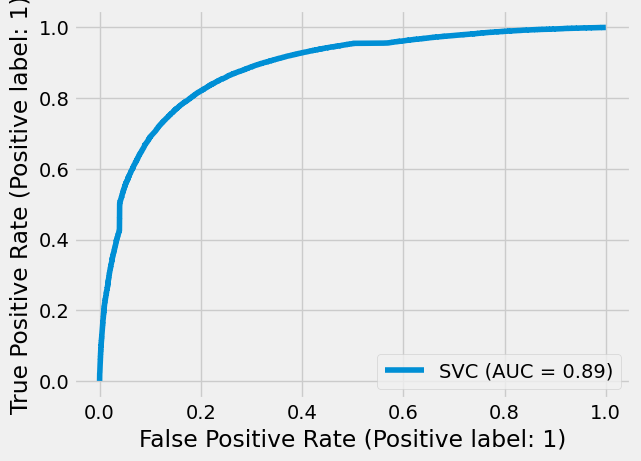

In [37]:
plot_roc_curve(svm_model, X_train, y_train) 

In [38]:
review = "SUPERB, I AM IN LOVE IN THIS PHONE"

In [39]:
review_vector = vectorizer.transform([review]) # vectorizing
print(svm_model.predict(review_vector.toarray()))

[1]


In [40]:
review = "Do not purchase this product. My cell phone blast when I switched the charger"

In [41]:
review_vector = vectorizer.transform([review]) # vectorizing
print(svm_model.predict(review_vector.toarray()))

[-1]


In [42]:
accuracies = cross_val_score(estimator = svm_model, X = X_train, y = y_train, cv = 2)



In [43]:
accuracies.mean()

0.7513179347826087

In [44]:
accuracies.std()

0.0015081521739130352

In [46]:
# pickling the vectorizer
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))
# pickling the model
pickle.dump(svm_model, open('svm_new_model.sav', 'wb'))